In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from DSH import MIfile as MI
from DSH import Config as cf
from DSH import ROIproc as RP
from DSH import SharedFunctions as sf
from DSH import IOfunctions as iof

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('ROI processing tutorial started')

INFO:root:ROI processing tutorial started


# Processing Regions Of Interest (ROIs)

```CorrMaps``` class is designed to compute correlations with maximum spatial resolution. This comes at the expense of computation time and of output size. When maximum spatial resolution is not the priority, it may be convenient to average the intensity correlation on fewer, extended Regions Of Interest (ROIs). This is done by the ```ROIproc``` class. We test it on a dummy dataset:

In [3]:
froot = r'..\ROI_test'
MIinput = MI.MIfile(os.path.join(froot, 'MI.raw'), os.path.join(froot, 'MI_metadata.ini'))
MIinput.OpenForReading()
im1 = MIinput.GetImage(0)
plt.imshow(im1)
plt.colorbar()

DEBUG:root:MIfile object created with filename ..\ROI_test\MI.raw
DEBUG:root:Now loading MIfile metadata (from filename: ..\ROI_test\MI_metadata.ini)


OSError: Configuration file ..\ROI_test\MI_metadata.ini not found

### Defining a set of ROIs

To define a set of ROIs, the fist thing required is a reference system. Both cartesian and polar coordinates are supported, and can be generated, for a given image shape, by calling:

```python
grid = SharedFunctions.PixelCoordGrid(shape, extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
```

where:
- ```shape``` is the shape of the map, in number of pixels ```[num_rows, num_cols]```
- ```extent``` is the cartesian extent of the mapping, in physical units ```[x_left, x_right, y_bottom, y_top]```. They can eventually be reversed (e.g. ```x_right<x_left```). If it is set to ```None```, it takes the default value ```[0, shape[1], shape[0], 0]```
- ```center``` is the origin of the coordinate system, in physical units
- ```angle``` is a parameter eventually rotating the coordinate system by a given angle, in radians. For cartesian coordinates, ```angle=0``` means $(x', y')=(x, y)$, whereas ```angle=pi/2``` means $(x', y')=(y, -x)$. For polar coordinates, ```angle=0``` means $\theta=0$ along $+x$, whereas ```angle=pi/2``` means $\theta=0$ along $+y$ (note: this means downwards if ```indexing='xy'```)
- ```coords``` is the choice of the coordinate system: set it to ```['cartesian'|'polar']``` to return ```[x,y]``` or ```[r,theta]``` respectively
- ```indexing``` is the choice of ```numpy.meshgrid``` indexing method. Set it to ```['xy'|'ij']``` to return cartesian coordinates or rows and columns 

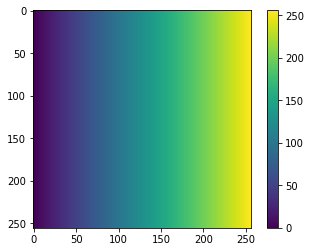

In [3]:
px_coords = sf.PixelCoordGrid(MIinput.ImageShape(), extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
plt.imshow(px_coords[0])
plt.colorbar()

Based on this set of coordinates, ROIs can be defined by their center coordinates and their extent: $(x, y, dx, dy)$ or $(r, \theta, dr, d\theta)$. The resulting set of ROIs is stored as a list of binary masks one for each ROI.

```python
ROI_masks = RP.GenerateMasks(coords, grid, common_mask=None)
```

where:
- ```coords``` is a list of mask coordinates in the form ```[x0, x1, dx0, dx1]```
- ```grid``` is a grid of coordinates, as generated by ```RP.PixelCoordGrid```
- ```common_mask``` eventually contains a common mask with pixels to be excluded from all ROIs



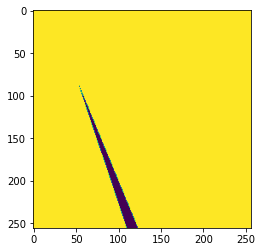

In [4]:
pxmask = MI.ReadBinary(os.path.join(froot, 'px_mask.raw'), MIinput.ImageShape(), 'B')
plt.imshow(pxmask)

A list of binary masks can also be visualized as an integer map, reporting the ROI index every pixel belongs to, using:

```python
RP.BinaryToIntegerMask(ROI_masks)
```

Note that regions of overlapping ROIs are not resolved by this visualization, but they are supported by ```ROIproc```, which uses independent binary masks for each ROI

DEBUG:root:4 binary masks created with shape (256, 256)


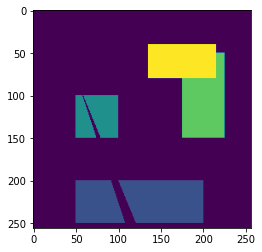

In [5]:
ROI_coords = [[125, 225, 150, 50], [75, 125, 50, 50], [200, 100, 50, 100], [175, 60, 80, 40]]
ROIs = RP.GenerateMasks(ROI_coords, px_coords, common_mask=pxmask)
plt.imshow(RP.BinaryToIntegerMask(ROIs))

The entire image can be tiled with ROIs using:

```python
ROI_grid, ROI_nodes = RP.GenerateROIgrid(px_coords, GridShape, coord_limits=None, common_mask=None)
```

where:
- ```px_coords``` is a grid of pixel coordinates, as generated by ```RP.PixelCoordGrid```
- ```GridShape``` is a couple ```(M,N)``` specifying the number of ROIs across each coordinate axis
- ```coord_limits``` eventually restricts the tiling to a subset of the entire space defined by its boundaries along each axis: ```[[min_x0, max_x0], [min_x1, max_x1]]```. If None, full axis span will be taken

DEBUG:root:16 binary masks created with shape (256, 256)


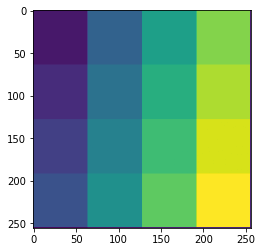

In [6]:
ROI_gridshape = (4, 4)
ROI_grid, ROI_nodes = RP.GenerateROIgrid(px_coords, ROI_gridshape)
plt.imshow(RP.BinaryToIntegerMask(ROI_grid))

### Processing ROIs

The core of a DLS analysis is to compute ROI-averaged statistics on image intensity $\langle I_p \rangle$. This is based on the function: 

```python
AvgRes, norm = RP.ROIAverage(image, ROImask, boolMask=False, weights=None, norm=None, masknans=False, dtype=float, evalFunc=None, evalParams={}, debug=False):
```

where:
- ```image```is either 2D image or 3D ndarray with list of images
- ```ROImask``` is either a list of 2D binary masks (if ```boolMask==True```) or a 2D int array with same size as image, with each pixel labeled with the index of the ROI it belongs to, 0-based (if ```boolMask==False```). In this case, each pixel can only belong to one ROI, and pixels not belonging to any ROI must be labeled with -1
- ```weights``` is a 2D float array, with the same shape as ```image```. If specified, the function computes a weighted average instead of a simple average.
- ```norm``` list of normalization factors (float), one per ROI. Equals the number of pixel belonging to each ROI if average is not weighted. If ```None``` (default), it is computed from ROImask. It can be passed as an argument to speed up the computation.
- ```masknans``` (bool). If true, assume the presence of NaNs in the array: mask them and don't count them in the normalization by setting their weight to zero. Set it to ```False``` if you are sure that there are no NaNs to improve calculation speed
- ```dtype``` datatype of the accumulator in which the elements are summed. If the accumulator is too small, np.sum generates overflow
- ```evalFunc``` if None, simple average will be computed. Otherwise, what will be averaged will be a function of the pixel values
- ```evalParams``` eventually specify additional parameters for evalFunc

The function returns:
- ```AvgRes```: If processing a single image (2D input): 1D float array with ROI-averaged data. If processing multiple images (3D input): 2D float array, one image per row, one ROI per column. If a bin contains NO DATA (e.g. empty ROI, or zero weights, or due to NaNs), it will have a NaN value because of the divide-by-sum-of-weights component.
- ```norm``` the normalization factor (sum of weights) for each ROI. If ```weights==None```, this is the number of pixels in the ROI

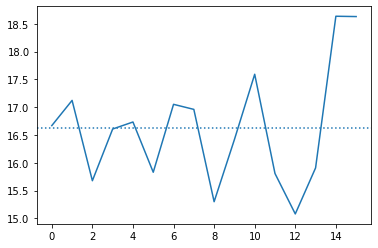

In [7]:
AvgRes, norm = RP.ROIAverage(im1, ROI_grid, boolMask=True)
plt.plot(AvgRes)
plt.axhline(np.mean(im1), ls=':')

To view it as a map:

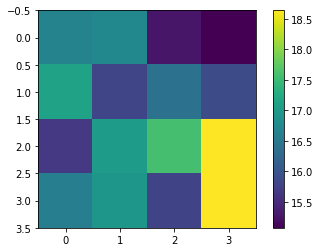

In [8]:
plt.imshow(AvgRes.reshape(ROI_gridshape).T)
plt.colorbar()

The same function can be used to compute image correlations $\langle I_p(t) I_p(t+\tau) \rangle$:

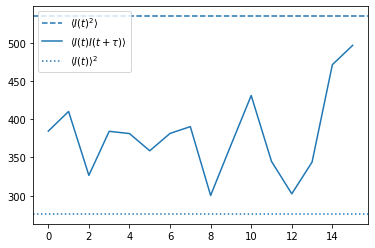

In [9]:
im2 = MIinput.GetImage(2)
XprodAvg, norm = RP.ROIAverage(im1*im2, ROI_grid, boolMask=True)
plt.axhline(np.mean(im1**2), ls='--', label=r'$\langle I(t)^2\rangle$')
plt.plot(XprodAvg, label=r'$\langle I(t)I(t+\tau)\rangle$')
plt.axhline(np.mean(im1)**2, ls=':', label=r'$\langle I(t)\rangle^2$')
plt.legend()

### The ROIproc class

The ```ROIproc``` class does this analysis on an input ```MIfile```. To initialize a ```ROIproc``` object:

```python
ROI_proc = RP.ROIproc(MIin, ROImasks, ROImetadata=None, imgTimes=None, expTimes=[1])
```

where:
- ```MIin``` is the input ```MIfile``` or ```MIstack``` to be processed.
- ```ROImasks``` is the list of binary masks Each mask is a 2D binary array with same shape as ```MIin.ImageShape()```. ```True``` values (nonzero) denote pixels that will be included in the analysis, ```False``` values (zeroes) will be excluded. If ```None```, all pixels will be included.
- ```ROImetadata``` eventually specifies a ```dict``` of ROI metadata.  Can contain one or more of the following keys:
    - ```'coords'``` : ndarray with ROI coordinates. If not set, ```ROIcoords=np.arange(self.CountROIs())```
    - ```'coord_names'``` : list of ```str```: coordinate names. If not set, ```ROIcoord_names = [coord0, coord1, ...]```
    - ```'box_margin'``` : positive ```int``` with margin left for drift measurement. Default: 0
- ```imgTimes``` is a ```float``` array of length ```MIin.ImageNumber()```. i-th element will be the time of the image in physical units. If ```None```, time will be measured in image units.

**NOTE: Image times and exposure times**

In typical experiments, images are acquired at a constant rate (FPS), specified in the metadata of each MIfile (see tutorial 1). However, there are cases in which custom acquisition schemes may be used to enhance the sensitivity to both the fastest and the slowest dynamics. In these cases, the time at which each image has beed taken (```imgTimes```) needs to be provided. It is usually saved in an ASCII file accompanying the raw file with the images. If this is the case, image times can be extracted using:

```python
im_times = RP.LoadImageTimes(img_times_source, usecols=0, skiprows=1, root_folder=None, return_unique=False)
```

where:
- ```img_times_source``` is the file name or list of filenames. If several filenames are given, results will be concatenated 
- ```usecols``` is index of the column in the file containing image times
- ```skiprows``` is the number of rows to be skipped at the beginning of the file
- ```root_folder``` is the root folder path. If specified, img_times_source will be interpreted as a relative path
- ```return_unique``` : if ```True```, remove duplicates before returning result

In addition, because sometimes the dynamic range of a typical 8bit camera is not enough to properly measure speckle patterns with spatially-modulated intensities, where the intensity may vary of several orders of magnitude, the same speckle field is typically recorded using multiple exposure times.
Combining images taken at different exposure time in one unique spectrum requires knowledge of the exposure times (```expTimes```).

In [10]:
ROI_proc = RP.ROIproc(MIinput, ROIs)
ROI_proc

INFO:root:Set 4 valid ROIs
DEBUG:root:10 image times automatically generated from MI metadata (fps=10.0Hz)
DEBUG:root:Set one single exposure time: 1


<ROIproc object: MIfile (..\ROI_test\MI.raw) + 4 ROIs>

In [11]:
print(ROI_proc)


|-----------------|
|  ROIproc class: |
|-----------------+---------------
| Input           : MIfile (..\ROI_test\MI.raw), 10 images
| ROIs            : 4 (4 valid, 0 empty)
| Exposure times  : 1, from 1 to 1
|-----------------+---------------


In [12]:
ROI_proc.imgTimes

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

The binary masks for the ROIs are stored in ```ROIproc.ROI_masks``` (or in its integer map form ```ROIproc.ROIs```):

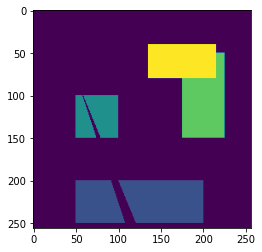

In [13]:
plt.imshow(RP.BinaryToIntegerMask(ROI_proc.ROI_masks))

```ROIproc``` stores also the area of each ROI, to speed up normalization of ```RP.ROIAverage```. It is saved in ```ROIproc.ROI_maskSizes```:

In [14]:
ROI_proc.ROI_maskSizes

array([6966, 2345, 5000, 3200])

To optimize computation, ```ROIproc``` stores the coordinates of the smallest box enclosing all ROIs in the form ```[min_row, min_col, max_row, max_col]``` in the variable ```ROIproc.ROIboundingBox``` or equivalently, in the form ```[topleftx, toplefty, width, height]``` in the variable ```self.CropROIbb```:

array([ 40,  50, 250, 225], dtype=int64)

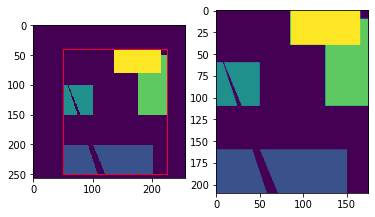

In [15]:
ROIbb = ROI_proc.BoundingBox
ROIbb2 = ROI_proc.CropROIbb
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(ROI_proc.ROIs, interpolation='none', extent=(0, ROI_proc.ROIs.shape[1], ROI_proc.ROIs.shape[0], 0))
ax[0].add_patch(patches.Rectangle((ROIbb[1], ROIbb[0]), ROIbb[3]-ROIbb[1], ROIbb[2]-ROIbb[0], edgecolor='m', facecolor='none'))
ax[0].add_patch(patches.Rectangle((ROIbb2[0], ROIbb2[1]), ROIbb2[2], ROIbb2[3], ls='-.', edgecolor='r', facecolor='none'))
ax[1].imshow(ROI_proc.ROIs[ROIbb[0]:ROIbb[2],ROIbb[1]:ROIbb[3]])
ROIbb

When this bounding box is specified, ```ROIproc``` reads the ROI instead of the full image when its functions ```ROIproc.GetImage(image_idx, buffer)``` and ```ROIproc.ReadMI()``` are called.

In addition, ```ROIproc``` stores the bounding boxes of every ROI in the form ```[min_row, min_col, max_row, max_col]```, where coordinates are defined *relative to the cropped image*, in the variable ```ROIproc.ROIboundingBoxes```.
If ROIs are not simple rectangles, ```ROIproc``` stores a cropped binary image of the ROIs restricted to their bounding boxes, in the variable ```ROIproc.ROI_masks_crop```. If all ROIs are simple full rectangles, such that ```ROIproc.ROI_masks_crop``` are all ones, ```ROIproc.ROI_masks_crop``` is set to ```None``` instead.

Bounding box shape is: (210, 175)
ROIboundingBoxes:
[[160   0 210 150]
 [ 60   0 110  50]
 [ 10 125 110 175]
 [  0  85  40 165]]


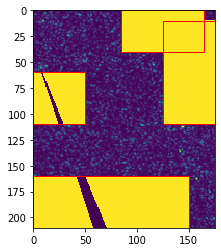

In [16]:
im1_crop = ROI_proc.GetImage(0)
print('Bounding box shape is: ' + str(im1_crop.shape))
fig, ax = plt.subplots()
ax.imshow(im1_crop, interpolation='none', extent=(0, ROI_proc.CropROIbb[2], ROI_proc.CropROIbb[3], 0))
for ridx in range(len(ROI_proc.ROIboundingBoxes)):
    _rbb = ROI_proc.ROIboundingBoxes[ridx]
    if ROI_proc.ROI_masks_crop is not None:
        ax.imshow(ROI_proc.ROI_masks_crop[ridx], interpolation='none', extent=(_rbb[1], _rbb[3], _rbb[2], _rbb[0]), vmin=0, vmax=1)
    ax.add_patch(patches.Rectangle((_rbb[1], _rbb[0]), _rbb[3]-_rbb[1], _rbb[2]-_rbb[0], edgecolor='r', facecolor='none'))
ax.set_xlim([0, ROI_proc.CropROIbb[2]])
ax.set_ylim([ROI_proc.CropROIbb[3], 0])

print('ROIboundingBoxes:')
print(ROI_proc.ROIboundingBoxes)

To further speed up the computation, these bounding boxes are given to the ```ROIAverage``` function, which then works on subsets of the whole image only. Because ```ROIproc``` contains both the ROIs and the input MIfile, computing ROIaverages only requires to specify the list of indexes of images to be processed. This is done in the function:
```python
AvgRes = ROIproc.ROIaverageIntensity(stack1, ROImasks=None, masks_isBool=False, no_buffer=False, imgs=None):
```

which is a special case of the more general function (with ```stack2==None```):
```python
AvgRes = ROIproc.ROIaverageProduct(stack1, stack2=None, ROImasks=None, masks_isBool=False, no_buffer=False, imgs=None):
```

where:

- ```stack1``` is a list of indexes. Images will be either read by MIinput or retrieved from img_buffer
- ```stack2``` is None, or list of indexes
         - if None: function will return averages of single images (in stack1)
         - if list: length should be the same as stack1
- ```ROImasks``` : 2D int array or 3D bool array: masks associating each pixel to a ROI
         - if 2D int array: pixel value will denote which ROI the pixel belongs to
         - if 3D bool array: i-th 2D array willbe True for pixels belonging to i-th ROI
         shape of each 2D mask has to match the image shape
         if None, self.ROIs will be used (which is of type int by default)
- ```masks_isBool``` : True or False to indicate that ROImasks is of bool or int type, respectively
- ```no_buffer``` : if True, avoid reading all images to a buffer, but read images one by one
            (dumping them afterwards)
- ```imgs``` : None or 3D array with buffered images. If None, images will be read from MIinput

The function returns a 2D array, with as many rows as the number of images and as many columns as the number of ROIs. ```AvgRes[i,j]``` is the average of i-th image on j-th ROI

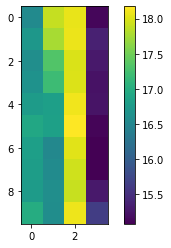

In [17]:
AvgRes = ROI_proc.ROIaverageIntensity()
plt.imshow(AvgRes)
plt.colorbar()

### Computing correlations

Dynamic light scattering (DLS) measures the two-times correlation of the detected intensity: $c(t, \tau)\propto\langle I_p(t) I_p(t+\tau) \rangle$, where the average $\langle \cdots \rangle$ is computed on pixels belonging to the same ROI. This can be computed using ```ROI_proc.ROIaverageProduct``` defined above:

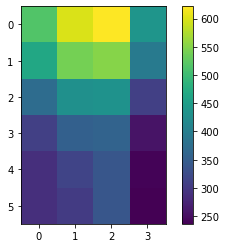

In [18]:
tau_list = [0,1,2,3,4,5]
AvgRes_num = ROI_proc.ROIaverageProduct([0]*len(tau_list), tau_list)
plt.imshow(AvgRes_num)
plt.colorbar()

Each column is a ROI, $\tau$ increases going downwards. The starting point for each column depende on $\langle I_p \rangle$, which is why it is interesting to normalize the correlation function. In principle, this is done using $\langle I_p(t) \rangle\langle I_p(t+\tau) \rangle$

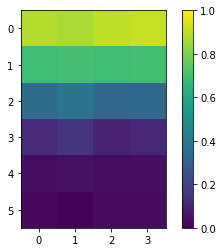

In [19]:
AvgRes_den = ROI_proc.ROIaverageIntensity(tau_list)
AvgRes_corr = np.empty_like(AvgRes_num)
for tau_idx in range(AvgRes_num.shape[0]):
    AvgRes_corr[tau_idx] = AvgRes_num[tau_idx]/(AvgRes_den[0]*AvgRes_den[tau_idx]) - 1
plt.imshow(AvgRes_corr, vmin=0, vmax=1)
plt.colorbar()

Normalization using $\langle I_p(t) \rangle\langle I_p(t+\tau) \rangle$ is not perfect, for some reason. For this reason, one can define a normalized correlation as in Duri et al., PRE 2005: $\tilde{c}(t, \tau)=2c(t, \tau)/[c(t, 0)+c(t+\tau, 0)]$. Note, for this example we only computed $t=0$ as a reference time so we use a simplified normalization with just $c(t, 0)$ as a denominator

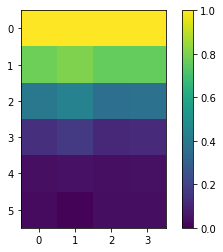

In [20]:
AvgRes_corrNorm = np.empty_like(AvgRes_corr)
for tau_idx in range(AvgRes_num.shape[0]):
    AvgRes_corrNorm[tau_idx] = AvgRes_corr[tau_idx]/AvgRes_corr[0]
plt.imshow(AvgRes_corrNorm, vmin=0, vmax=1)
plt.colorbar()

This matrix was generated using 0-th image as reference frame. Correlation timetraces $c_I(t, \tau)$ are computed by repeating this calculation for all time points (until $t+\tau$ exceeds the total duration of the image sequence)

In [21]:
total_corr = np.nan * np.ones((ROI_proc.CountROIs(), ROI_proc.ImageNumber(), len(tau_list)))
all_avgs = ROI_proc.ROIaverageIntensity()
for tidx in range(ROI_proc.ImageNumber()):
    lidx_list = [lidx for lidx in range(len(tau_list)) if tidx+tau_list[lidx] < all_avgs.shape[0]]
    cur_avgProd = ROI_proc.ROIaverageProduct([tidx]*len(lidx_list), [tidx+tau_list[lidx] for lidx in lidx_list])
    for lidx in lidx_list:
        total_corr[:,tidx,lidx] = cur_avgProd[lidx]/(all_avgs[tidx]*all_avgs[tidx+tau_list[lidx]]) - 1
# d0 correction (proper version)
for tidx in range(ROI_proc.ImageNumber()):
    for lidx in [lidx for lidx in range(len(tau_list)) if tidx+tau_list[lidx] < all_avgs.shape[0]]:
        total_corr[:,tidx,lidx] /= 0.5 * (total_corr[:,tidx,0] + total_corr[:,tidx+tau_list[lidx],0])
total_corr[:,:,0] = 1

We should find the above matrix as special $t=0$ case

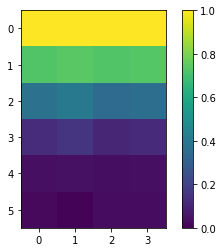

In [22]:
plt.imshow(total_corr[:,0,:].T, vmin=0, vmax=1)
plt.colorbar()

Otherwise we can show correlation for one ROI, as a function of time (rows) and time delay (columns):

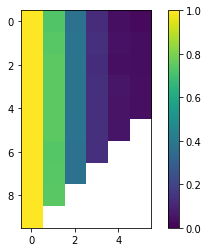

In [23]:
plt.imshow(total_corr[0], vmin=0, vmax=1)
plt.colorbar()

The code above is integrated in the function:

```python
corr = ROIproc.CalcCorrelation(t1, t2, d0corr=True)
```

where:
- ```t1``` and ```t2``` are image times to be correlated, in image units.$
  They are ```int``` or list of ```int```. If they are both ```int```, output is 1D.
  If one of them is ```int``` or 1-element list, it will be replicated to match the legth of the other list.
  If both t1 and t2 are lists (they should be equal size), correlation will be computed between each ```(t1[i], t2[i])``` couple.
  
- ```d0corr``` is a boolean flag. Set it to ```False``` to return the raw $c(t_1, t_2)=\langle I(t_1)I(t_2)\rangle/[\langle I(t_1)\rangle\langle I(t_2)\rangle]$. Set it to ```True``` to return the normalized $\tilde{c}(t_1, t_2)=2c(t_1, t_2)/[c(t_1, t_1)+c(t_2, t_2)]$

INFO:root:ROIproc.CalcCorrelation(): single first time (0) replicated 6 times to match length of second time (6).


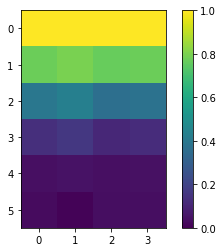

In [24]:
plt.imshow(ROI_proc.CalcCorrelation(0, tau_list, d0corr=True), vmin=0, vmax=1)
plt.colorbar()

### Time averaging correlations

Finally, time-averaged correlation functions $g_2(\tau)-1=\langle c_I(t, \tau)\rangle_t$ can be computed by averaging two-point correlations $c_I(t, \tau)$ on the reference time, $t$. This can be done using:

```python
g2m1, g2m1_lags, [g2m1_err] = ROIproc.AverageCorrTimetrace(CorrData, ImageTimes, Lagtimes_idxlist, avg_interval=None, img_indexes=None, return_stderr=False, sharp_bound=False, lag_tolerance=1e-2, lag_tolerance_isrelative=True)
```

where:

- ```CorrData``` is the input correlation timetraces (2D float array). Element ```[i,j]``` is correlation between ```t[i]``` and ```t[i]+tau[j]```
- ```ImageTimes``` is the array of image times (1D float array). i-th element is the physical time at which i-th image was taken
- ```Lagtimes_idxlist``` is the list of lagtimes, in image units (1D int array). NOTE: they must be positive. Not yet compatible with negative time lags
- ```avg_interval``` can be either ```None```, ```int```, couple of ints ```interval=[min_idx, max_idx]``` or list of couples ```[interval1, ..., intervalN]```. 
    - if ```None``` or ```int<=0```, result will be averaged on the entire stack
    - if ```int>0```, resolve the average on consecutive chunks of ```avg_interval``` images each
    - if ```[min_idx, max_idx, [step_idx=1]]```, average will be done in the specified interval
    - if ```[interval1, ..., intervalN]```, a list of intervals will be computed as above
- ```img_indexes```: ```None``` or 1D array, ```int```. Index of reference image relative to i-th row of ```CorrData``` array. if ```None``` (default), ```img_indexes=[0,1,...,CorrData.shape[0]-1]```. Specify it when ```CorrData``` was computed using a subset of reference times
- ```return_stderr```: bool. If ```True```, return standard deviation of the correlation points averaged to obtain the g2-1
- ```sharp_bound```: ```bool```. 
    - if ```False```, use interval bounds to associate any reference time to the corresponding interval, but average on all time lags, including those for which ref_time + time_lag >= max_idx
    - if ```True```, for each reference time, restrict average such that both correlated timepoints are in the specified interval
- ```lag_tolerance``` : ```float```. Time lags closer than ```lag_tolerance``` will be averaged together
- ```lag_tolerance_isrelative``` : ```bool```
    - if ```False```, time lags $\tau_i$ and $\tau_j$ will be averaged together if $|\tau_i-\tau_j|<$ ```lag_tolerance```
    - if ```True```, the criterion will be that $\left|2(\tau_i-\tau_j)/(\tau_i+\tau_j)\right|<$ ```lag_tolerance```

The function returns:

- ```g2m1```: 2D array. Element ```[i,j]``` represents j-th lag time and i-th time-resolved chunk
- ```g2m1_lags```: 2D array. It contains the time delays, in physical units, of the respective correlation data
- ```g2m1_stderr```: 2D array. Element ```[i,j]``` represents the standard deviation of the data averaged to obtain ```g2m1[i,j]```. It is only returned if ```return_stderr==True```

DEBUG:root:[0 1 2 3 4 5 6 7 8 9]
DEBUG:root:0


g2-1 averaged on 1 time intervals (3 lagtimes each)


<ErrorbarContainer object of 3 artists>

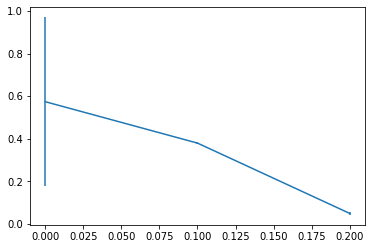

In [25]:
g2m1, g2m1_lags, g2m1_err = RP.AverageCorrTimetrace(total_corr[0], ROI_proc.imgTimes, tau_list, avg_interval=None, return_stderr=True)
print('g2-1 averaged on {0} time intervals ({1} lagtimes each)'.format(g2m1.shape[0], g2m1.shape[1]))
plt.errorbar(g2m1_lags[0], g2m1[0], yerr=g2m1_err[0])

```ROIproc.AverageCorrTimetrace``` also works with non-uniform time acquisition ("multitau" or "smart time sampling"), when the same time delay in image units corresponds to different time delays in physical units, depending on the reference time. The reconstruction of time delays in physical units is done by the auxiliary function

```python
alllags, unique_laglist = SharedFunctions.FindLags(series, lags_index, refs_index=None, subset_intervals=None, tolerance=1e-2, tolerance_isrelative=True)
```

where:

- ```series``` is a list of time points (float), not necessarily equally spaced
- ```lags_index``` is a list of positive lag indexes (int, >=0). WARNING: not yet compatible with negative lag indexes
- ```refs_index```: list of reference time indexes (int, >=0). If ```None``` (default), it will be set to ```[0,1,...,len(series)-1]```. WARNING: ```refs_index``` needs to be in ascending order, needs to have no duplicated elements and all elements need to be in the ```[0,len(series)]``` interval
- ```subset_intervals``` is ```None``` or list of intervals ```[min_idx, max_idx]```. Eventually divide the analysis in intervals based on first (reference) time. If None, it will be set to the entire section
- ```tolerance``` and ```tolerance_isrelative``` are parameters controlling the coarse graining of unique lag times, to avoid having many lag times slightly different because of floating point precision
                
The function returns:

- ```alllags```: 2D list (float if series is float). ```alllags[i][j] = series[j+lag[i]] - series[j]``` NOTE: this is not a square matrix, as ```len(alllags[i])``` depends on i (no element is added to the list if ```j+lag[i] >= len(series)```)
- ```unique_laglist```:   2D list. Element ```[i][j]``` is j-th lagtime of i-th analyzed subsection, coarse-grained to identify all lags closer together than the defined ```tolerance```

In [26]:
g2m1_alllags, g2m1_laglist = sf.FindLags(ROI_proc.imgTimes, tau_list, sf.ValidateAverageInterval(7, ROI_proc.ImageNumber()))
print(tau_list)
g2m1_laglist #TODO: logging added in SharedFunctions.py line 555 (sf.FindLags)

DEBUG:root:[[0, 7, 1], [7, 10, 1]]
DEBUG:root:[0, 7, 1]


TypeError: '>=' not supported between instances of 'list' and 'int'

In [ ]:
test_timeseries = sf.SmartTimeSamplingSeries(minimum_delay=0.1, pair_duration=1, cycle_duration=3, num_points=13)
lag_idx = [1,2,6]
alllags, unique_laglist = sf.FindLags(test_timeseries, lag_idx)
print('Generated {0} timepulses for smart time sampling: {1}'.format(len(test_timeseries), test_timeseries))
print('{0} lagtimes in image units {1} generated {2} unique lagtimes in physical units {3}'.format(len(lag_idx), lag_idx, len(unique_laglist[0]), unique_laglist[0]))
print('alllags[i] is the list of physical time lags generated by i-th lagtime (in image units)')
print('Example: i={0} (d{1}) generates {2}'.format(0, lag_idx[0], alllags[0]))

### Complete analysis

This multi-step analysis can be run through the function:
```python
ROIproc.doDLS(saveFolder, lagtimes, reftimes='all', drift_corr=0, no_buffer=False, force_SLS=True, save_transposed=False, include_negative_lags=False)
```

where:

- ```saveFolder```: folder path to export analysis output
- ```lagtimes```: ```'all'``` or list of ```int```.
    - If ```'all'```, all available lagtimes will be processed
    - Otherwise, only specified lagtimes will be processed
- ```reftimes```: ```'all'``` or list of ```int```.
    - If ```'all'```, all reference times will be used
    - Otherwise, specialize the analysis to a subset of reference times specified in the list
- ```drift_corr```: positive integer to compute drift-corrected correlations (see below)
- ```no_buffer```: If ```True```, avoid reading full MIfile to RAM. It saves memory but slows down processing.
- ```force_SLS```: If ```False```, program will load previously computed SLS results if available.
- ```save_transposed```: specifies the format of correlation timetrace output
    - if ```False```, classic cI output: one line per reference time, one column per time delay
    - if ```True```, transposed output: one line per time delay, one column per reference time
- ```include_negative_lags```: eventually include negative lagtime in the analysis
    - if ```False``` (default), only process prositive lagtimes. If ```reftimes=='all'```, negative lagtimes are redundant and ```include_negative_lags``` will be set to ```False```. 
    - If sparse ```reftimes``` are processed, set ```include_negative_lags==True``` to include negative lagtimes

In [ ]:
%%time
fout=os.path.join(froot, 'out')
ROI_proc.doDLS(fout, lagtimes='all', reftimes='all', drift_corr=0, no_buffer=False, force_SLS=True, save_transposed=False)

If the number of logging lines generated by this function is too large, it can be lowered by setting the ```ROI_proc.LoopMaxInfoN``` parameter:

In [ ]:
ROI_proc.LoopMaxInfoN = 3
ROI_proc.doDLS(fout, lagtimes='all', reftimes='all', drift_corr=0, no_buffer=False, force_SLS=True, save_transposed=False)

The final step of the analysis computes the time-averaged correlation functions $g_2(\tau)-1$ from two-point correlations $c_I(t, \tau)$. This can be done after the analysis using:

```python
ROI_proc.AverageG2M1(folder_path, avg_interval=None, search_prefix=['cI_','cIcr_','dx_','dy_'], save_prefix=['g2m1','g2m1cr','avgdx','avgdy'], save_stderr=False, sharp_bound=False, lag_tolerance=1e-2, lag_tolerance_isrelative=True)
```

where:

- ```folder_path```: folder path containing cI-like output files to be loaded and time-averaged. Output data is also saved in ```folder_path```.
- ```avg_interval```:  ```None```, ```int```, single interval ```[min_idx, max_idx, [step_idx=1]]``` or list of intervals ```[interval1, ..., intervalN]```, as in the ```ROIproc.AverageCorrTimetrace``` function described above.
- ```search_prefix``` and ```save_prefix```: lists of ```str```. Number of elements in ```save_prefix``` must match that of ```search_prefix```. For each file with a given ```search_prefix```, the output g2m1 file will have the corresponding ```save_prefix```.
- ```save_stderr```: ```bool```. If ```save_stderr==False```, the output file will have ```2N``` columns, one per reference time. Columns will be: ```[tau_1, g2m1_1, tau_2, g2m1_2, ..., tau_N, g2m1_N]```. Otherwise, the function will also calculate the standard deviation of the correlation values being averaged, and save it into an additional column. In this case, columns in the output file will be: ```[tau_1, g2m1_1, g2m1err_1, tau_2, g2m1_2, g2m1err_2, ..., tau_N, g2m1_N, g2m1err_N]```.
- ```sharp_bound```: ```bool```. If you want ```avg_interval``` to restrict not only the reference time $t$, but also the later time $t+\tau$, set ```sharp_bound=True```. 
- ```lag_tolerance```, ```lag_tolerance_isrelative```. Parameters specifying the criterion to group *equal* time delays together (see ```ROIproc.AverageCorrTimetrace``` above for details)

This function loads all cI-like output files from the specified ```folder_path``` (cI-like is defined by the ```.dat``` extension and a prefix included in the list of prefixes specified in ```search_prefix```), average correlation data with the same timelag and save them to g2-1 files, replacing the prefix with the corresponding one specified in ```save_prefix```.

In [ ]:
ROI_proc.AverageG2M1(fout, avg_interval=[2,6], sharp_bound=True)

When analyzing a limited set of reference times and a large number of lagtimes, it may be convenient to save a transposed version of the correlation timetraces, with one time delay per row and one reference time per column. The result can be obtained activating the ```save_transposed``` flag. In this case, one can also include the negative time delays, too, by using ```include_negative_lags=True```

In [ ]:
%%time
fout_trans=os.path.join(froot, 'out_trans')
ROI_proc.doDLS(fout_trans, lagtimes='all', reftimes=[0, 4, 8], drift_corr=0, no_buffer=False, force_SLS=True, save_transposed=True, include_negative_lags=True)

### Visualizing output

Analysis result is saved in the specified output folder. 
Several output files will be generated:

- **analysis_log.txt**: log file keeping track of analysis steps performed and time taken to perform each step
- ROIproc configuration
    - **ROIcoords.dat**: ROI coordinates, if given, and normalization factors (ROI areas)
    - **ROImask.raw**: raw image (data type: 32bit integer, signed, no header, same shape as original image). Pixel value is the index of the ROI that pixel belongs to (0-based, as in the DLS filenames), and -1 for pixel not belonging to any ROI
    - **ROIprocConfig.ini**: configuration file containing analysis and ```ROIproc``` parameters
    - **imgTimes.dat**: list of image times
- SLS output:
    - **Iavg_raw.dat**: ROI-averaged image intensity for each input image (one per exposure time, if multiple exposure times are present). Ageraged intensity is already normalized by the exposure time
    - **exptimes.dat**: optimal exposure time for each ROI and acquired image
    - **Iavg.dat**: ROI-averaged optimal image intensity for each input image (obtained selecting the optimal exposure time reported in exptimes.dat)
- DLS output:
    - **cI_ROIxxx_eyy.dat**: correlation timetraces, where xxx is the ROI index and yy the exposure time index
    - **g2m1_ROIxxx_eyy.dat**: time-averaged correlation functions
- Drift-corrected DLS output:
    - **cIcr_ROIxxx_eyy.dat**: timetrace of the peak of spatial crosscorrelation
    - **g2m1cr_ROIxxx_eyy.dat**: time-averaged decay of crosscorrelation peak
    - **dx_ROIxxx_eyy.dat**, **dy_ROIxxx_eyy.dat** x and y components of the correlation peak drift
    - **avgdx_ROIxxx_eyy.dat**, **avgdy_ROIxxx_eyy.dat** time-averaged x and y components of the correlation peak drift

In [ ]:
for i in os.listdir(fout):
    print(i)

A few functions in ```IOfunctions``` make it easier to read these output files:

```python
# To open a generic ASCII file with results:
res_arr[, hdr_list][, firstcol] = IOfunctions.LoadResFile(fname, readHeader=True, isolateFirst=0, delimiter=',', comments='#')
```

The function returns:
- ```res_arr```: a 1D or 2D array with data in the input file
- ```hdr_list```: a list of header entries ```(str)```, as many as the number of columns in ```res_arr``` (independently of ```isolateFirst```). Header is the first line of the ASCII file. Only returned if ```readHeader==True```
- ```firstcol```: a 1D or 2D array with the first ```isolateFirst``` initial columns, isolated from the rest of the data. Only returned if ```isolateFirst>0```

```python
# To open Iavg_raw.dat
Iav, roi_coords, times, exptimes = IOfunctions.OpenRawSLS(fname, roi_numcoords=2, delimiter='\t', comments='#')
```

The function returns:
- ```Iav```: a 2D or 3D array with ROI-averaged intensities. ```Iav[i,j,k]``` is the average on ```i```-th ROI of the image taken at ```j```-th time with ```k```-th exposure time. If only one time or one exposure time are present, the result is squeezed to a 2D array
- ```roi_coords```: a 1D or 2D array, depending on ```roi_numcoords```, with the ROI coordinates
- ```times```: 1D or 2D array array with image times for each SLS spectrum ```Iav[:,j,k]``` or ```Iav[:,j]```, in physical units (default: seconds)
- ```exptimes```: 1D or 2D array array with exposure times for each SLS spectrum, in physical units (default: milliseconds)

In [ ]:
Iav, roi_coords, times, exptimes = iof.OpenRawSLS(os.path.join(fout, 'Iavg_raw.dat'), roi_numcoords=1)
print('Iav.shape  = ' + str(Iav.shape))
print('roi_coords = ' + str(roi_coords))
print('times      = ' + str(times))
print('exptimes   = ' + str(exptimes))

```python
# To open Iavg.dat
Iav, roi_coords, times = IOfunctions.OpenSLS(fname, roi_numcoords=2, delimiter='\t', comments='#')
```

The function returns:
- ```Iav```: a 2D array with ROI-averaged intensities. ```Iav[i,j]``` is the average on ```i```-th ROI of the image taken at ```j```-th time with the best exposure time.
- ```roi_coords```: a 1D or 2D array, depending on ```roi_numcoords```, with the ROI coordinates
- ```times```: 1D array array with image times for each SLS spectrum ```Iav[:,j]```, in physical units (default: seconds)

In [ ]:
Iav, roi_coords, times = iof.OpenSLS(os.path.join(fout, 'Iavg.dat'), roi_numcoords=1)
print('Iav.shape  = ' + str(Iav.shape))
print('roi_coords = ' + str(roi_coords))
print('times      = ' + str(times))

```python
# To open cI_ROIxxx_eyy.dat
cI_data, times, lagidx_list = IOfunctions.ReadCIfile(fpath, time_colidx=1, delimiter='\t', comments='#')
```

The function returns:
- ```cI_data```: a 2D array with two-time correlation values. ```cI_data[i,j]``` is the correlation between image taken at ```i```-th time (as specified in the ```reftimes``` parameter of ```ROI_proc.doDLS```) with the image taken at a time set by the ```j```-th lagtime (as specified in the ```lagtimes``` parameter of ```ROI_proc.doDLS```).
- ```times```: 1D array array with times of each reference image, in physical units (default: seconds)
- ```lagidx_list```: 1D array with lagtimes in image units ```(int)```

In [ ]:
cI_data, times, lagidx_list = iof.ReadCIfile(os.path.join(fout, 'cI_ROI000_e00.dat'))
print('cI_data.shape = ' + str(cI_data.shape))
print('times         = ' + str(times))
print('lagidx_list   = ' + str(lagidx_list))
for i in range(len(lagidx_list)):
    plt.plot(times, cI_data[:,i], label='d'+str(lagidx_list[i]))
plt.legend()

```python
# To open transposed cI_ROIxxx_eyy.dat
trans_cI_data, lagtimes, reftime_idx_list = IOfunctions.ReadCIfile(fpath, time_colidx=1, delimiter='\t', comments='#')
```

The function returns:
- ```trans_cI_data```: a 2D array with two-time correlation values. ```trans_cI_data[i,j]``` is the correlation between image taken at ```j```-th time (as specified in the ```reftimes``` parameter of ```ROI_proc.doDLS```) with the image taken at a time set by the ```i```-th lagtime (as specified in the ```lagtimes``` parameter of ```ROI_proc.doDLS```).
- ```lagtimes```: 1D array array with lag times of each reference image, in image units
- ```reftime_idx_list```: 1D array with reference times in image units ```(int)```

In [ ]:
trans_cI_data, lagtimes, reftime_idx_list = iof.ReadCIfile(os.path.join(fout_trans, 'cI_ROI000_e00.dat'), time_colidx=0)
print('trans cI_data.shape = ' + str(trans_cI_data.shape))
print('lag times           = ' + str(lagtimes))
print('reftime_idx_list    = ' + str(reftime_idx_list))
for i in range(len(reftime_idx_list)):
    plt.plot(lagtimes, trans_cI_data[:,i], label='t'+str(reftime_idx_list[i]))
plt.legend()

```python
# To open all cI_*.dat files in folder
cI_data, times, lagidx_list, ROI_list, exptime_list = IOfunctions.OpenCIs(froot, fname_prefix='cI_', time_colidx=1, delimiter='\t', comments='#')
```

The function returns:
- ```cI_data```: list of 2D arrays, each one as returned by ```IOfunctions.ReadCIfile```
- ```times```, ```lagidx_list```: lists of 1D arrays with times and lagtimes, one element per ROI (they should be all equal)
- ```ROI_list```, ```exptime_list```: list of ROI and exptime indices

In [ ]:
cI_data, times, lagidx_list, ROI_list, exptime_list = iof.OpenCIs(fout)
print('cI_data: {0} elements, each of shape {1}'.format(len(cI_data), cI_data[0].shape))
print('times: {0} elements, first element: {1}'.format(len(times), times[0]))
print('lagidx_list: {0} elements, first element: {1}'.format(len(lagidx_list), lagidx_list[0]))
print('ROI_list ({0} elements): {1}'.format(len(ROI_list), ROI_list))
print('exptime_list ({0} elements): {1}'.format(len(exptime_list), exptime_list))

```python
# To open one or all g2m1_*.dat files in folder
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = IOfunctions.OpenG2M1s(froot, expt_idx=None, roi_idx=None, fname_prefix='g2m1_', time_colidx=1, delimiter='\t', comments='#')
```

If specified, ```expt_idx``` and/or ```roi_idx``` filter the selection to the given exposure time and ROI indexes

The function returns:
- ```g2m1_data```: list of 2D arrays, each one with correlation functions $g_2(\tau)-1$ for one given ROI. They can eventually be time-resolved: one column per time point. The first row ($\tau=0$) reports the contrast (```d0```) before normalization
- ```lagtimes```: lists of 2D arrays with lagtimes relative to ```g2m1_data``` points, in physical units (the same as times in cI data)
- ```imgtimes```: list of 1D arrays with timepoints relative to columns in ```g2m1_data```, in physical units
- ```ROI_list```, ```exptime_list```: list of ROI and exptime indices

In [ ]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout)
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()

```python
# To open ROIcoords.dat
ROIcoords, ROInames, NormFact, ROIbb = IOfunctions.LoadROIcoords(file_name, delimiter='\t', comments='#')
```

The function returns:
- ```ROIcoords```: a 1D or 2D array with ROI coordinates
- ```ROInames```: a list of ```str``` with names of ROI coordinates
- ```NormFact```: a 1D array with number of pixels in each ROI
- ```ROIbb```: 2D array array with 4 columns and 1 row per ROI, with ROI bounding boxes in the format ```[min_row, min_col, max_row, max_col]``` relative to the global bounding box

In [ ]:
ROIcoords, ROInames, NormFact, ROIbb = iof.LoadROIcoords(os.path.join(fout, 'ROIcoords.dat'))
print(ROInames)
print(ROIcoords)
fig, ax = plt.subplots()
ax.imshow(im1_crop, interpolation='none', extent=(0, ROI_proc.CropROIbb[2], ROI_proc.CropROIbb[3], 0))
for ridx in range(len(ROI_proc.ROI_masks_crop)):
    _rbb = ROIbb[ridx]
    ax.add_patch(patches.Rectangle((_rbb[1], _rbb[0]), _rbb[3]-_rbb[1], _rbb[2]-_rbb[0], edgecolor='r', facecolor='none'))

### Load config or analysis from file

```ROIproc.ExportConfiguration()```, called with ```doDLS```, saves all the configuration files needed to reinitialize ```ROIproc``` together with the whole analysis. 
The configuration file can be directly imported into a ```Config``` object:

In [ ]:
out_config = cf.Config(os.path.join(fout, 'ROIprocConfig.ini'))
print(out_config)

This configuration can be used to re-run the analysis with the same parameters, using the function

```python
ROI_proc.RunFromConfig(ConfigParams, AnalysisSection='Analysis', OutputSubfolder='reproc', export_configparams=None)
```

where:
- ```ConfigParams``` is the full path of the config file to read or a Config object containing the analysis parameters
- ```AnalysisSection``` is the name of the configuration section containing analysis parameters
- ```OutputSubfolder``` is the name of the subfolder to save the analysis output. Root folder would be the ```Analysis.out_folder``` field. Set it to ```None``` to save the output in ```Analysis.out_folder```
- ```export_configparams``` is a ```dict``` eventually containing additional parameters to export with the analysis configuration file

In [ ]:
ROI_proc.RunFromConfig(out_config)

The configuration file can also be used to load a new ```ROIproc``` object and eventually re-run the analysis, using the function

```python
ROI_proc_reload = RP.LoadFromConfig(ConfigParams, runAnalysis=True)
```

where:
- ```ConfigParams``` is the full path of the config file to read or a dict or a Config object
- ```runAnalysis=True``` runs the analysis after initializing the object using ```ROI_proc.RunFromConfig```

In [ ]:
ROI_proc_reload = RP.LoadFromConfig(out_config, runAnalysis=True)

In [ ]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(os.path.join(fout, 'reproc'))
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()

A simpler .ini file can also be manually configured to run the analysis:

In [ ]:
roi_config = cf.Config(os.path.join(froot, 'config', 'ROIprocConfig_manual.ini'))
print(roi_config)

In [ ]:
ROI_proc_manual = RP.LoadFromConfig(os.path.join(froot, 'config', 'ROIprocConfig_manual.ini'), runAnalysis=True)

In [ ]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(os.path.join(froot, 'out_manualconfig'))
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()